In [48]:
import numpy as np
import random
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.metrics import classification_report, balanced_accuracy_score
import json
import os
from optuna.visualization import plot_optimization_history
import matplotlib.pyplot as plt

In [49]:
SEED = 1234
 # Se puede cambiar a "precision" o "recall" o "f1-score"
SCORE = "f1-score"

In [50]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)

Score Trend Changes Score

In [51]:
def get_trend_changes_report_dict(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(
        y_df["is_changed_trend_test"][:-1], 
        y_df["is_changed_trend_predict"][:-1], 
        digits=4,
        output_dict=True,
        zero_division=0
    )

def trend_changes_score(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(
        y_df["is_changed_trend_test"][:-1], 
        y_df["is_changed_trend_predict"][:-1], 
        digits=4
    )

def trend_changes_true(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    report = classification_report(
        y_df["is_changed_trend_test"][:-1],
        y_df["is_changed_trend_predict"][:-1],
        output_dict=True,
        zero_division=0
    )
    return report["True"][SCORE]

In [52]:
# Cargar datos
train = pd.read_csv("../../../data/post_cleaning/training_set.csv", parse_dates=["date"])
val = pd.read_csv("../../../data/post_cleaning/validation_set.csv", parse_dates=["date"])
test_set = pd.read_csv("../../../data/post_cleaning/test_set.csv", parse_dates=['date'])
X_train = train.drop(columns=["date", "target_trend"]).values
y_train = train["target_trend"].values
X_val = val.drop(columns=["date", "target_trend"]).values
y_val = val["target_trend"].values
X_test = test_set.drop(columns=['target_trend','date']).values
y_test = test_set['target_trend'].values

In [53]:
# Mapear clases (-1,0,1) -> (0,1,2) para LightGBM
cls_map = {-1:0, 0:1, 1:2}
inv_map = {v:k for k,v in cls_map.items()}
y_train_m = np.vectorize(cls_map.get)(y_train)
y_val_m   = np.vectorize(cls_map.get)(y_val)
y_test_m  = np.vectorize(cls_map.get)(y_test)

# Pesos de clase (inverso de la frecuencia)
from collections import Counter
cnt = Counter(y_train_m)
total = len(y_train_m)
class_weight = {c: total/(len(cnt)*n) for c,n in cnt.items()}

In [54]:
def objective(trial):
    set_seeds(SEED)  # Fijar semilla antes de cada trial
    # Hiperparámetros a optimizar
    param = {
        "objective": "multiclass",
        "num_class": 3,
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "metric": ["multi_logloss"],
        "verbosity": -1,
        "seed": SEED
    }

    # Dataset y pesos igual que antes
    lgb_train = lgb.Dataset(X_train, label=y_train_m, weight=[class_weight[c] for c in y_train_m])
    lgb_val = lgb.Dataset(X_val, label=y_val_m, weight=[class_weight[c] for c in y_val_m], reference=lgb_train)

    model = lgb.train(
        param,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_val],
        valid_names=["val"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False)
        ]
    )

    # Predicción y métrica personalizada
    y_val_prob = model.predict(X_val, num_iteration=model.best_iteration)
    y_val_pred_m = y_val_prob.argmax(axis=1)
    # y_val_pred = np.vectorize(inv_map.get)(y_val_pred_m)
    score = trend_changes_true(y_val_m, y_val_pred_m)

    return score  # Optuna maximiza este valor

In [55]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=750)

[I 2025-08-24 19:21:20,127] A new study created in memory with name: no-name-49b51cc4-7d79-43a1-8602-785c666a16d2


[I 2025-08-24 19:21:24,835] Trial 0 finished with value: 0.3142857142857143 and parameters: {'learning_rate': 0.010134344267417028, 'num_leaves': 68, 'max_depth': 7, 'feature_fraction': 0.9141434334855076, 'bagging_fraction': 0.9119903232475214, 'bagging_freq': 3, 'min_data_in_leaf': 35}. Best is trial 0 with value: 0.3142857142857143.
[I 2025-08-24 19:21:25,667] Trial 1 finished with value: 0.3582089552238806 and parameters: {'learning_rate': 0.09629801567849108, 'num_leaves': 97, 'max_depth': 11, 'feature_fraction': 0.7431269079831466, 'bagging_fraction': 0.8003980502093835, 'bagging_freq': 7, 'min_data_in_leaf': 74}. Best is trial 1 with value: 0.3582089552238806.
[I 2025-08-24 19:21:27,158] Trial 2 finished with value: 0.3283582089552239 and parameters: {'learning_rate': 0.019594488244047626, 'num_leaves': 63, 'max_depth': 8, 'feature_fraction': 0.6055073798362729, 'bagging_fraction': 0.9091306486449496, 'bagging_freq': 9, 'min_data_in_leaf': 43}. Best is trial 1 with value: 0.3582

In [56]:
# Visualizar el historial de optimización
plot_optimization_history(study)

In [57]:
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor score de {SCORE}: {study.best_value:.4f}")
best_params = study.best_params

Mejores hiperparámetros encontrados:
{'learning_rate': 0.16080058075197093, 'num_leaves': 52, 'max_depth': 3, 'feature_fraction': 0.7551032572036344, 'bagging_fraction': 0.912287213632062, 'bagging_freq': 8, 'min_data_in_leaf': 65}
Mejor score de f1-score: 0.5373


In [28]:
# Guardar los mejores hiperparámetros y su valor
history = []
if os.path.exists("best_hyperparams.json"):
    try:
        with open("best_hyperparams.json", "r") as f:
            history = json.load(f)
    except (json.JSONDecodeError, ValueError):
        history = []

# Guardar ambos en un solo diccionario
history.append({
    "params": study.best_params,
    "value": study.best_value
})
# Guardar el historial de hiperparámetros
with open("best_hyperparams.json", "w") as f:
    json.dump(history, f, indent=2)

In [45]:
# Cargar historial de hiperparámetros y valores
import json

with open("best_hyperparams.json", "r") as f:
    history = json.load(f)

# Escoger el último (más reciente)
best_params = history[-1]["params"]
best_value = history[-1]["value"]

# Si quieres ver todos:
for i, entry in enumerate(history):
    print(f"Hiperparámetros #{i+1}: {entry['params']}, Valor: {entry['value']}")

# Si quieres escoger uno específico (por índice):
# best_params = history[indice_que_quieras]["params"]
# best_value = history[indice_que_quieras]["value"]

Hiperparámetros #1: {'learning_rate': 0.16080058075197093, 'num_leaves': 52, 'max_depth': 3, 'feature_fraction': 0.7551032572036344, 'bagging_fraction': 0.912287213632062, 'bagging_freq': 8, 'min_data_in_leaf': 65}, Valor: 0.5373134328358209
Hiperparámetros #2: {'learning_rate': 0.16080058075197093, 'num_leaves': 52, 'max_depth': 3, 'feature_fraction': 0.7551032572036344, 'bagging_fraction': 0.912287213632062, 'bagging_freq': 8, 'min_data_in_leaf': 65}, Valor: 0.5373134328358209


In [46]:
# Entrenar modelo final con los mejores hiperparámetros de Optuna
set_seeds(SEED)
final_params = best_params.copy()
final_params.update({
    "objective": "multiclass",
    "num_class": 3,
    "metric": ["multi_logloss"],  # Igual que en Optuna
    "verbosity": -1,
    "seed": SEED
})

# Re-crear los Dataset para evitar cualquier caché de pre-filtro
lgb_train = lgb.Dataset(X_train, label=y_train_m, weight=[class_weight[c] for c in y_train_m])
lgb_val   = lgb.Dataset(X_val,   label=y_val_m,   weight=[class_weight[c] for c in y_val_m], reference=lgb_train)

final_model = lgb.train(
    final_params,
    lgb_train,
    num_boost_round=1000,  # Igual que en Optuna
    valid_sets=[lgb_val],  # Igual que en Optuna
    valid_names=["val"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True)  # Igual que en Optuna
    ]
)

# Predicciones con el modelo final
y_val_prob = final_model.predict(X_val, num_iteration=final_model.best_iteration)
y_val_pred = y_val_prob.argmax(axis=1)
print("LightGBM FINAL report trend change score:\n",
      trend_changes_score(y_val_m, y_val_pred))

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[110]	val's multi_logloss: 0.312023
LightGBM FINAL report trend change score:
               precision    recall  f1-score   support

       False     0.9385    0.9421    0.9403       259
        True     0.5455    0.5294    0.5373        34

    accuracy                         0.8942       293
   macro avg     0.7420    0.7357    0.7388       293
weighted avg     0.8929    0.8942    0.8935       293



In [47]:
# Reporte completo: precisión, recall y F1 por clase
report = classification_report(y_val_m, y_val_pred, digits=4)
print("LightGBM Report:\n", report)
print("Balanced accuracy:", balanced_accuracy_score(y_val_m, y_val_pred))

LightGBM Report:
               precision    recall  f1-score   support

           0     0.8611    0.9894    0.9208        94
           1     1.0000    0.4390    0.6102        41
           2     0.9286    0.9811    0.9541       159

    accuracy                         0.9082       294
   macro avg     0.9299    0.8032    0.8284       294
weighted avg     0.9170    0.9082    0.8955       294

Balanced accuracy: 0.8031727226144202


In [30]:
# Obtener predicciones para el set test
y_test_prob = final_model.predict(X_test, num_iteration=final_model.best_iteration)
y_test_pred = y_test_prob.argmax(axis=1)
print("LightGBM Trend Changes Score:\n", trend_changes_score(y_test, y_test_pred))

LightGBM Trend Changes Score:
               precision    recall  f1-score   support

       False     0.9313    0.9278    0.9295       263
        True     0.4062    0.4194    0.4127        31

    accuracy                         0.8741       294
   macro avg     0.6688    0.6736    0.6711       294
weighted avg     0.8759    0.8741    0.8750       294



In [31]:
# Obtener predicciones para el set train
y_train_prob = final_model.predict(X_train, num_iteration=final_model.best_iteration)
y_train_pred = y_train_prob.argmax(axis=1)
print("LightGBM Trend Changes Score:\n", trend_changes_score(y_train, y_train_pred))

LightGBM Trend Changes Score:
               precision    recall  f1-score   support

       False     0.9975    0.9984    0.9979      1219
        True     0.9869    0.9805    0.9837       154

    accuracy                         0.9964      1373
   macro avg     0.9922    0.9894    0.9908      1373
weighted avg     0.9964    0.9964    0.9964      1373



In [33]:
# Reporte completo: precisión, recall y F1 por clase
report = classification_report(y_test_m, y_test_pred, digits=4)
print("LightGBM Report:\n", report)
print("Balanced accuracy:", balanced_accuracy_score(y_test_m, y_test_pred))

LightGBM Report:
               precision    recall  f1-score   support

           0     0.8304    0.9588    0.8900        97
           1     0.0000    0.0000    0.0000        26
           2     0.9432    0.9651    0.9540       172

    accuracy                         0.8780       295
   macro avg     0.5912    0.6413    0.6147       295
weighted avg     0.8230    0.8780    0.8489       295

Balanced accuracy: 0.6412930552225685


In [36]:
# --- Exportar y Comparar Métricas de Modelos (Validación) ---

# 1. Definir el nombre del modelo actual y el archivo de salida
model_name = 'lightGBM'
output_file = '../../../score_models/model_comparison_metrics.csv'

# 2. Calcular el reporte de clasificación estándar
# Usamos y_val_m y y_val_pred que están en la misma escala (0,1,2)
report_dict = classification_report(y_val_m, y_val_pred, output_dict=True, zero_division=0)
precision = report_dict['macro avg']['precision']
recall = report_dict['macro avg']['recall']
f1_score = report_dict['macro avg']['f1-score']


# 3. Calcular el reporte de cambio de tendencia
report = get_trend_changes_report_dict(y_val_m, y_val_pred)
trend_change_precision = report['True']['precision']
trend_change_recall = report['True']['recall']
trend_change_f1_score = report['True']['f1-score']

# 4. Organizar las nuevas métricas
new_metrics = {
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'trend_change_precision': trend_change_precision,
    'trend_change_recall': trend_change_recall,
    'trend_change_f1_score': trend_change_f1_score
}

# 5. Cargar, actualizar y guardar el DataFrame de comparación
try:
    # Intentar cargar el archivo existente
    comparison_df = pd.read_csv(output_file, index_col='model')
    # Si existe, actualizar o añadir la fila para el modelo actual
    comparison_df.loc[model_name] = new_metrics
except FileNotFoundError:
    # Si no existe, crear un DataFrame nuevo directamente con los datos actuales
    comparison_df = pd.DataFrame([new_metrics], index=[model_name])

# Guardar el DataFrame actualizado en el CSV
comparison_df.to_csv(output_file, index_label='model')

--- Resultados del Backtesting (Dataset Completo) ---
Capital Inicial: $1,000.00
Valor Final del Portafolio: $391,114.30
Retorno Total de la Estrategia: 39011.43%
Retorno de Comprar y Mantener (Buy & Hold): 1097.89%


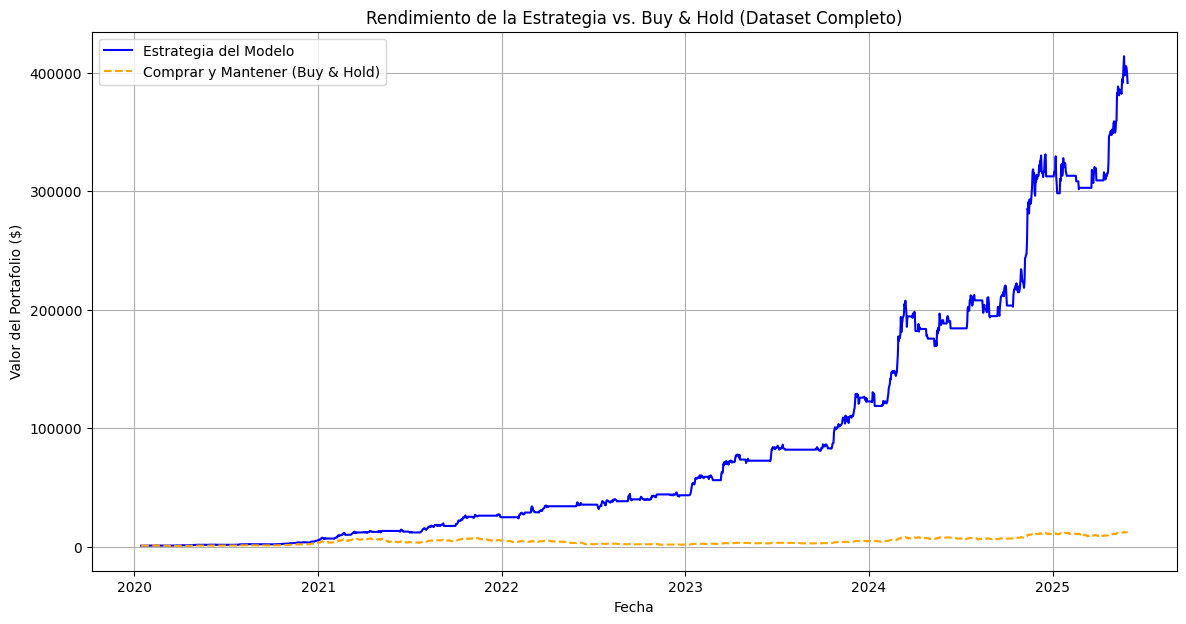

In [ ]:
# --- Backtesting con el dataset completo --- (PRUEBA PRUEBA)

# 1. Cargar el dataset completo
full_data = pd.read_csv("../../../data/post_cleaning/final_data.csv", parse_dates=['date'])
X_full = full_data.drop(columns=['date', 'target_trend']).values
y_full = full_data['target_trend'].values

# 2. Obtener predicciones para todo el dataset
y_full_prob = final_model.predict(X_full, num_iteration=final_model.best_iteration)
y_full_pred_m = y_full_prob.argmax(axis=1)
y_full_pred = np.vectorize(inv_map.get)(y_full_pred_m)

# 3. Crear DataFrame para el backtest
backtest_df_full = full_data.copy()
backtest_df_full['signal'] = y_full_pred

# 4. Identificar la columna de precios
price_col = [col for col in full_data.columns if 'open_d0' in col][-1]

# --- Simulación de Backtesting ---
initial_capital = 1000.0
cash = initial_capital
position = 0.0
portfolio_values = []

for i, row in backtest_df_full.iterrows():
    price = row[price_col]
    signal = row['signal']
    
    # Lógica de trading
    if signal == 1 and cash > 0:  # Señal de compra
        position = cash / price
        cash = 0.0
    elif signal == -1 and position > 0:  # Señal de venta
        cash = position * price
        position = 0.0
    
    # Calcular valor del portafolio
    current_portfolio_value = cash + position * price
    portfolio_values.append(current_portfolio_value)

backtest_df_full['portfolio_value'] = portfolio_values

# --- Cálculo de Métricas y Visualización ---
final_portfolio_value = backtest_df_full['portfolio_value'].iloc[-1]
total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100
buy_and_hold_return_pct = (backtest_df_full[price_col].iloc[-1] - backtest_df_full[price_col].iloc[0]) / backtest_df_full[price_col].iloc[0] * 100

print("--- Resultados del Backtesting (Dataset Completo) ---")
print(f"Capital Inicial: ${initial_capital:,.2f}")
print(f"Valor Final del Portafolio: ${final_portfolio_value:,.2f}")
print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")

# Visualizar los resultados
plt.figure(figsize=(14, 7))
plt.plot(backtest_df_full['date'], backtest_df_full['portfolio_value'], label='Estrategia del Modelo', color='blue')

buy_and_hold_values = (backtest_df_full[price_col] / backtest_df_full[price_col].iloc[0]) * initial_capital
plt.plot(backtest_df_full['date'], buy_and_hold_values, label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')

plt.title('Rendimiento de la Estrategia vs. Buy & Hold (Dataset Completo)')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()

--- Resultados del Backtesting ---
Capital Inicial: $10,000.00
Valor Final del Portafolio: $18,817.31
Retorno Total de la Estrategia: 88.17%
Retorno de Comprar y Mantener (Buy & Hold): 71.17%


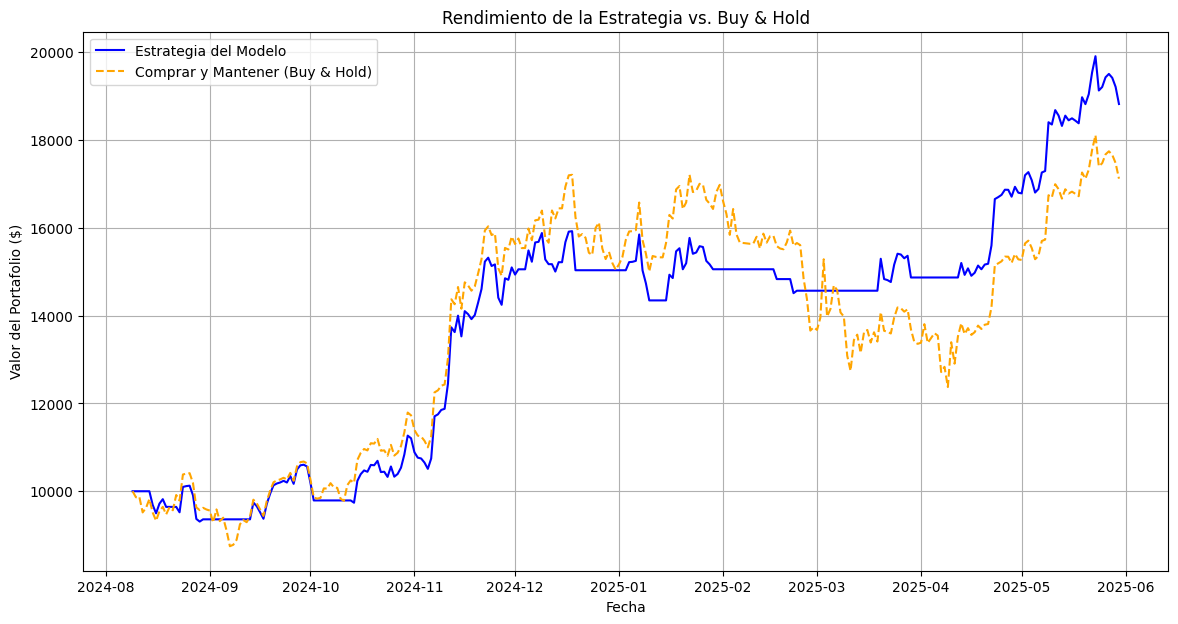

In [ ]:
# # --- Preparación de Datos para Backtesting ---

# # 1. Obtener predicciones para el conjunto de prueba y mapearlas a -1, 0, 1
# y_pred_test = np.vectorize(inv_map.get)(y_test_pred)

# # 2. Crear un DataFrame para el backtest
# # Usamos una copia del test_set original que contiene precios y fechas
# backtest_df = test_set.copy()
# backtest_df['signal'] = y_pred_test

# # La columna de precio que usaremos es la del día más reciente en la ventana deslizante
# # Basado en tu notebook dataCleaning.ipynb, esta columna debería existir. 
# # Si el nombre es diferente, ajústalo aquí.
# price_col = [col for col in test_set.columns if 'open_d0' in col][-1]


# # --- Simulación de Backtesting ---

# initial_capital = 10000.0
# cash = initial_capital
# position = 0.0  # Unidades de BTC
# portfolio_values = []

# for i, row in backtest_df.iterrows():
#     price = row[price_col]
#     signal = row['signal']
    
#     # Lógica de trading
#     if signal == 1 and cash > 0:  # Señal de compra
#         position = cash / price
#         cash = 0.0
#     elif signal == -1 and position > 0:  # Señal de venta
#         cash = position * price
#         position = 0.0
    
#     # Calcular el valor actual del portafolio
#     current_portfolio_value = cash + position * price
#     portfolio_values.append(current_portfolio_value)

# backtest_df['portfolio_value'] = portfolio_values


# # --- Cálculo de Métricas y Visualización ---

# # 1. Calcular métricas de rendimiento
# final_portfolio_value = backtest_df['portfolio_value'].iloc[-1]
# total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100
# buy_and_hold_return_pct = (backtest_df[price_col].iloc[-1] - backtest_df[price_col].iloc[0]) / backtest_df[price_col].iloc[0] * 100

# print("--- Resultados del Backtesting ---")
# print(f"Capital Inicial: ${initial_capital:,.2f}")
# print(f"Valor Final del Portafolio: ${final_portfolio_value:,.2f}")
# print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
# print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")

# # 2. Visualizar los resultados
# plt.figure(figsize=(14, 7))
# plt.plot(backtest_df['date'], backtest_df['portfolio_value'], label='Estrategia del Modelo', color='blue')

# # Normalizar el precio para comparar con "Buy & Hold"
# buy_and_hold_values = (backtest_df[price_col] / backtest_df[price_col].iloc[0]) * initial_capital
# plt.plot(backtest_df['date'], buy_and_hold_values, label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')

# plt.title('Rendimiento de la Estrategia vs. Buy & Hold')
# plt.xlabel('Fecha')
# plt.ylabel('Valor del Portafolio ($)')
# plt.legend()
# plt.grid(True)
# plt.show()